In [2]:
import pandas as pd
import csv
import glob
import os.path
import matplotlib.pyplot as plt
import seaborn as sns

## Read in the dataset and filter empty data

In [3]:
def insert_to_table(data: pd.DataFrame, table_name:str):
    db = create_engine(conn_string)
    conn = db.connect()
    data.to_sql(table_name, conn, if_exists="replace", index=False)
    conn.close()

In [4]:
def extract_from_csv(file_to_process: str) -> pd.DataFrame:
    with open(file_to_process, 'r') as file:
        reader = csv.reader(file)
        header = next(reader)

    data = pd.read_csv(file_to_process)
    data = data.dropna(axis=1, how='all')
    extracted_data = pd.DataFrame(columns = header)
    extracted_data = pd.concat([extracted_data, data], ignore_index=True)
    return extracted_data

In [5]:
def filter_df(df: pd.DataFrame) -> pd.DataFrame:

    # drop empty cols
    df = df.dropna(axis=1, how='all')

    # drop rows with only age and everything else null
    filtered_rows_index = df[~(df.drop(columns=['age']).isnull().all(axis=1) & ~df['age'].isnull())].index
    df = df.loc[filtered_rows_index]
    df['age'] = pd.to_numeric(df['age'], errors='coerce')


    # drop rows with all nan
    df = df[~df.isnull().all(axis=1)]

    return df

## DB Connection

In [ ]:
# !pip install psycopg2-binary

In [ ]:
# import psycopg2

# # Connect to the PostgreSQL database
# conn = psycopg2.connect(
#     dbname="heart_disease",
#     user="de300",
#     password="pass123",
#     host="localhost",
#     port="5432"
# )

# # Create a cursor object
# cur = conn.cursor()

# # # Execute a SQL query
# # cur.execute("SELECT * FROM my_table")

# # # Fetch the results
# # results = cur.fetchall()

# # # Print the results
# # for row in results:
# #     print(row)

# # # Close the cursor and connection
# cur.close()
# conn.close()

## Compute and analyze the various statistical measures

In [6]:
initial_df = extract_from_csv("./heart_disease.csv")
df = filter_df(initial_df)

/tmp/ipykernel_186/3615485252.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  extracted_data = pd.concat([extracted_data, data], ignore_index=True)


In [7]:
# first 5 rows of data
df.head(5)

,age,sex,painloc,painexer,relrest,cp,trestbps,htn,chol,smoke,...,exeref,exerwm,thal,thalsev,thalpul,earlobe,cmo,cday,cyr,target
0,63.0,1.0,NaN,NaN,NaN,1.0,145.0,1.0,233.0,NaN,...,NaN,NaN,6.0,NaN,NaN,NaN,2.0,16.0,81.0,0.0
1,67.0,1.0,NaN,NaN,NaN,4.0,160.0,1.0,286.0,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,2.0,5.0,81.0,1.0
2,67.0,1.0,NaN,NaN,NaN,4.0,120.0,1.0,229.0,NaN,...,NaN,NaN,7.0,NaN,NaN,NaN,2.0,20.0,81.0,1.0
3,37.0,1.0,NaN,NaN,NaN,3.0,130.0,0.0,250.0,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,2.0,4.0,81.0,0.0
4,41.0,0.0,NaN,NaN,NaN,2.0,130.0,1.0,204.0,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,2.0,18.0,81.0,0.0


In [8]:
# renaming ekgday(day to ekgday for consistency
df = df.rename(columns={'ekgday(day': 'ekgday'})

In [9]:
# Define the columns as numerical or categorical based on information from the dataset documentation

column_types = {
    'age': 'numerical', 
    'sex': 'categorical', 
    'painloc': 'categorical', 
    'painexer': 'categorical', 
    'relrest': 'categorical', 
    'pncaden': 'numerical', 
    'cp': 'categorical', 
    'trestbps': 'numerical', 
    'htn': 'categorical', 
    'chol': 'numerical', 
    'smoke': 'categorical', 
    'cigs': 'numerical', 
    'years': 'numerical', 
    'fbs': 'categorical', 
    'dm': 'categorical', 
    'famhist': 'categorical', 
    'restecg': 'categorical', 
    'ekgmo': 'categorical', 
    'ekgday': 'categorical', 
    'ekgyr': 'categorical', 
    'dig': 'categorical', 
    'prop': 'categorical', 
    'nitr': 'categorical', 
    'pro': 'categorical', 
    'diuretic': 'categorical', 
    'proto': 'categorical', 
    'thaldur': 'numerical', 
    'thaltime': 'numerical', 
    'met': 'numerical', 
    'thalach': 'numerical', 
    'thalrest': 'numerical', 
    'tpeakbps': 'numerical', 
    'tpeakbpd': 'numerical', 
    'dummy': 'numerical', 
    'trestbpd': 'numerical', 
    'exang': 'categorical', 
    'xhypo': 'categorical', 
    'oldpeak': 'numerical', 
    'slope': 'categorical', 
    'rldv5': 'numerical', 
    'rldv5e': 'numerical', 
    'ca': 'numerical', 
    'exerckm': 'numerical', 
    'restef': 'numerical', 
    'restwm': 'categorical', 
    'exeref': 'numerical', 
    'exerwm': 'categorical', 
    'thal': 'categorical', 
    'thalsev': 'numerical', 
    'thalpul': 'numerical', 
    'earlobe': 'numerical', 
    'cmo': 'categorical', 
    'cday': 'categorical', 
    'cyr': 'categorical', 
    'target': 'categorical'
}

cat_cols = [key for key, value in column_types.items() if value == 'categorical']
num_cols = [key for key, value in column_types.items() if value == 'numerical']

In [10]:
# analyzing the features of the df
def get_info(df: pd.DataFrame):
    res = df.describe().transpose()
    print(res.shape)
    res['missing_percent'] = [(df.shape[0] - res.loc[ind, 'count'])/df.shape[0] for ind in res.index]
    res['unique_val'] = [len(df.loc[:,ind].value_counts()) for ind in res.index]
    res['var_type'] = res.index.map(column_types)
    
    csv_file_path = "data_info.csv"
    res.to_csv(csv_file_path)
    
    return res

In [11]:
info = get_info(df)
info

(54, 8)


,count,mean,std,min,25%,50%,75%,max,missing_percent,unique_val,var_type
age,899.0,53.480534,9.435894,28.00,47.0000,54.00,60.000,77.0,0.000000,50,numerical
sex,899.0,0.790879,0.406908,0.00,1.0000,1.00,1.000,1.0,0.000000,2,categorical
painloc,617.0,0.920583,0.270607,0.00,1.0000,1.00,1.000,1.0,0.313682,2,categorical
painexer,617.0,0.593193,0.491637,0.00,0.0000,1.00,1.000,1.0,0.313682,2,categorical
relrest,613.0,0.672104,0.469830,0.00,0.0000,1.00,1.000,1.0,0.318131,2,categorical
cp,899.0,3.253615,0.928499,1.00,3.0000,4.00,4.000,4.0,0.000000,4,categorical
trestbps,840.0,132.101190,19.151127,0.00,120.0000,130.00,140.000,200.0,0.065628,60,numerical
htn,865.0,0.476301,0.499727,0.00,0.0000,0.00,1.000,1.0,0.037820,2,categorical
chol,869.0,198.759494,111.834415,0.00,175.0000,224.00,269.000,603.0,0.033370,213,numerical
smoke,230.0,0.517391,0.500787,0.00,0.0000,1.00,1.000,1.0,0.744160,2,categorical


(54, 8)


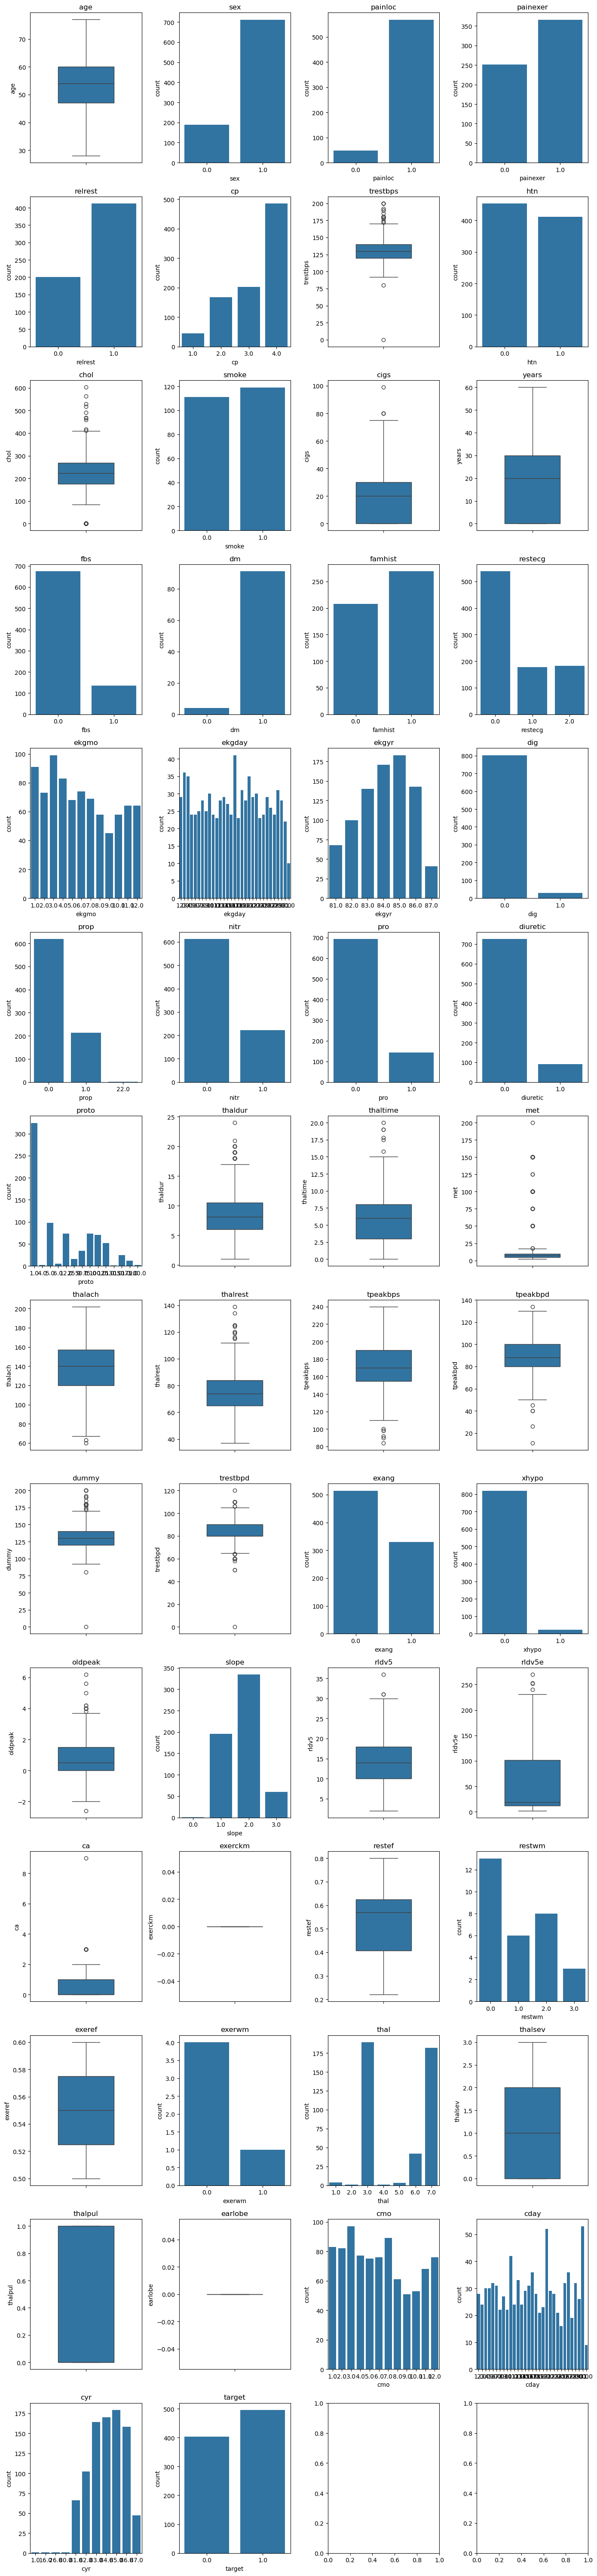

In [12]:
info = get_info(df)

fig,axs = plt.subplots(14,4,figsize=(14,60))

for i,ind in enumerate(info.index):

    if info.loc[ind, 'var_type'] == 'numerical':
        sns.boxplot(df,y=ind,ax=axs[i//4, i%4],width=0.5)
        

    else:
        sns.countplot(data=df,x=ind,color='#1f77b4',ax=axs[i//4, i%4])
    
    axs[i//4, i%4].set_title(ind)

fig.tight_layout()

Some things that I notice from the summary table and visualization:
1. There are a lot of outliers
2. Many columns only have a few values
3. A lot of features are categorical with 0 and 1

### Missing values

There seem to be a lot of missing values from the columns.

In [13]:
data_missing = (df.isnull().sum()/df.shape[0]).round(2)
data_missing[data_missing > 0]

painloc     0.31
painexer    0.31
relrest     0.32
trestbps    0.07
htn         0.04
chol        0.03
smoke       0.74
cigs        0.47
years       0.48
fbs         0.10
dm          0.89
famhist     0.47
ekgmo       0.06
ekgday      0.06
ekgyr       0.06
dig         0.08
prop        0.07
nitr        0.07
pro         0.07
diuretic    0.09
proto       0.12
thaldur     0.06
thaltime    0.50
met         0.12
thalach     0.06
thalrest    0.06
tpeakbps    0.07
tpeakbpd    0.07
dummy       0.07
trestbpd    0.07
exang       0.06
xhypo       0.06
oldpeak     0.07
slope       0.34
rldv5       0.47
rldv5e      0.16
ca          0.68
exerckm     1.00
restef      0.97
restwm      0.97
exeref      1.00
exerwm      0.99
thal        0.53
thalsev     0.86
thalpul     0.95
earlobe     1.00
cmo         0.01
cday        0.01
cyr         0.01
dtype: float64

## Analyze missing values and come up with a strategy to impute them. You might need different imputation methods for different features. Justify your choices.

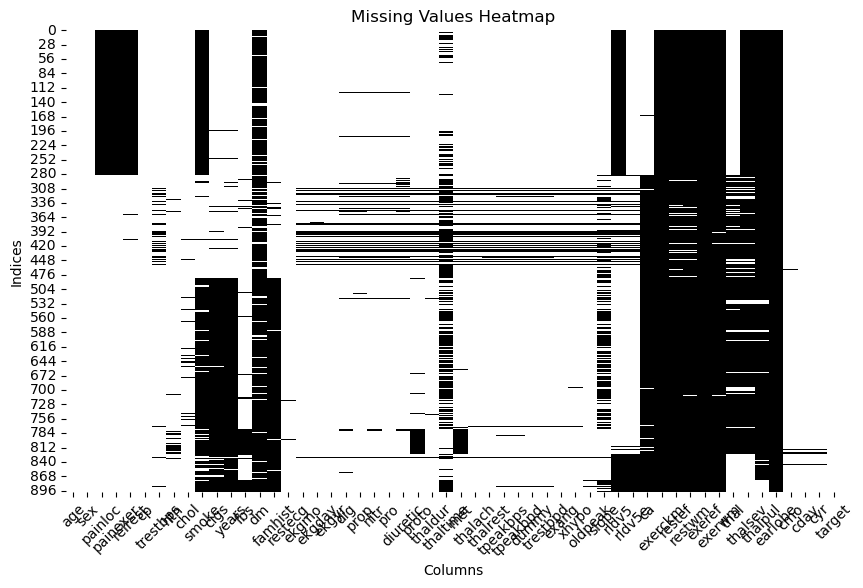

In [14]:
missing_indices = {}
for column in df.columns:
    missing_indices[column] = df.index[df[column].isna()].tolist()

# for column, indices in missing_indices.items():
#     print(f"Missing indices for column '{column}': {indices}")

# Create a heatmap of missing indices
plt.figure(figsize=(10, 6))
sns.heatmap(df.isna(), cmap='binary', cbar=False)
plt.title('Missing Values Heatmap')
plt.xlabel('Columns')
plt.ylabel('Indices')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

I am filling in the missing values for pncaden, which is the whole column. Based on the documentation, this is supposed to be a sum of ['painloc', 'painexer', 'relrest'].

In [15]:
# this column is supposed to be the sum of three pain values
df['pncaden'] = df[['painloc', 'painexer', 'relrest']].sum(axis=1)

The black bars show the missing values. There seem to be chunks of missing values for the most part.

One option would be to fill the categorical values to be the mean of the others. The mode would not be a good choice because it would heavily skew the data since there are a lot of missing values, so it would impact the average a lot.
I think a more appropriate way to fill them would be to create a model that uses the other values in the table to predict them because this would still allow for categorical values (ie. 0 and 1 rather than fraction). This is too complex to do right now without further analysis of the data.

The numerical values can be filled in with the mean or mode. I still think a model would be a better way to fill these in, but I need to do more analysis first.

For now, I will leave the missing values as NaN as not to skew the data incorrectly throughout my EDA.

### Unused, but this how I would fill the missing values

In [ ]:
# One option would be to fill the categorical values to be the mean of the others
df_filled = df

avg_cat_values = df_filled[cat_cols].mean()

df_filled[cat_cols] = df_filled[cat_cols].fillna(avg_cat_values)

# this column is supposed to be the sum of three pain values
df_filled['pncaden'] = df_filled[['painloc', 'painexer', 'relrest']].sum(axis=1)

In [ ]:
info_filled = get_info(df_filled)
info_filled

In [ ]:
# filling the numerical values to be the mode of the others
print(num_cols)
mode_num_values = df_filled[num_cols].mode().iloc[0]
print(mode_num_values)

df_filled[num_cols] = df_filled[num_cols].fillna(mode_num_values)


In [ ]:
info_filled = get_info(df_filled)
info_filled

## For the numerical features, identify outliers and appropriately deal with them. Justify your choices

In [16]:
len(df[num_cols].count()[df[num_cols].count() > 5])

22

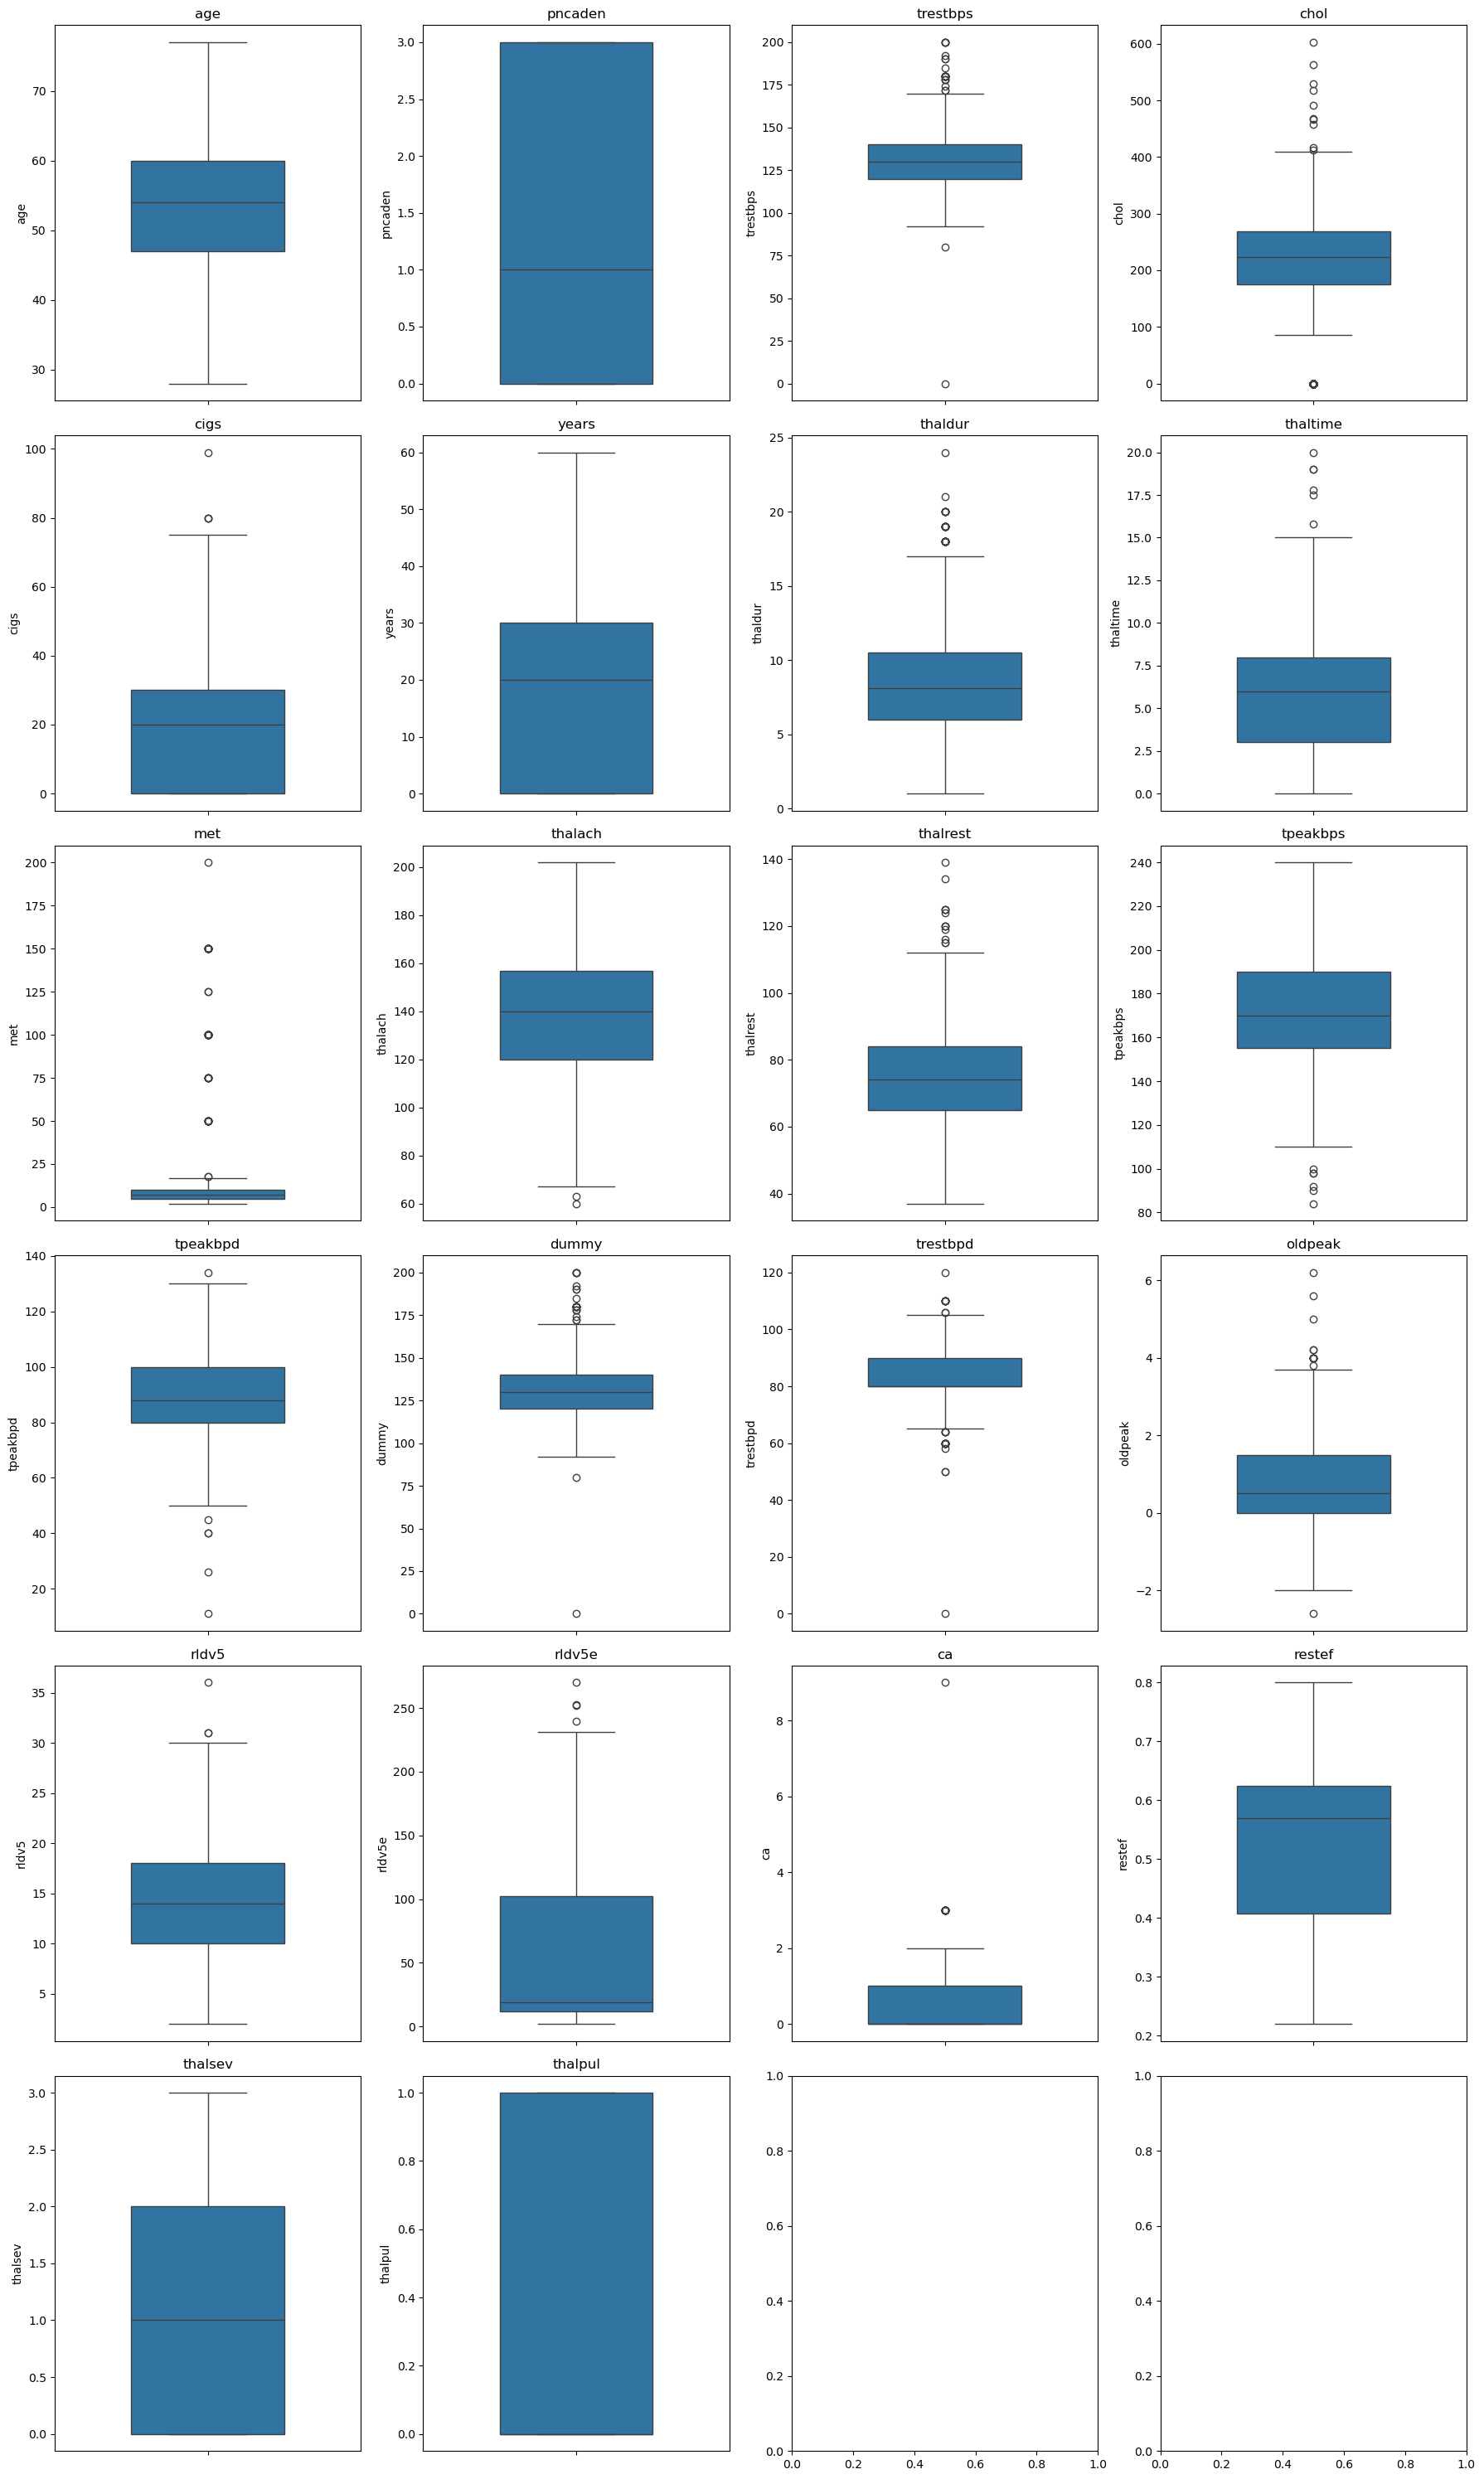

In [17]:
fig,axs = plt.subplots(6,4,figsize=(18,30))
i = 0

for ind in num_cols:

    if df[ind].count() > 5:
        sns.boxplot(df,y=ind,ax=axs[i//4, i%4],width=0.5)
        axs[i//4, i%4].set_title(ind)
        i+=1

fig.tight_layout()

In [18]:
for i,ind in enumerate(num_cols):

    print(i + 1, ": " + ind + "\n")

    mean = df[ind].mean()
    std = df[ind].std()

    outliers = df[ind][(df[ind] < (mean - 2 * std)) | (df[ind] > (mean + 2 * std))]
    print(outliers)
    print('-----------')


1 : age

101    34.0
132    29.0
161    77.0
225    34.0
233    74.0
257    76.0
305    74.0
313    77.0
357    75.0
372    75.0
403    74.0
407    76.0
419    74.0
422    75.0
455    74.0
470    74.0
517    32.0
538    31.0
549    32.0
558    32.0
589    34.0
597    33.0
601    34.0
608    34.0
653    29.0
686    31.0
691    28.0
698    30.0
702    29.0
706    33.0
750    34.0
754    32.0
777    32.0
796    34.0
798    74.0
858    73.0
Name: age, dtype: float64
-----------
2 : pncaden

Series([], Name: pncaden, dtype: float64)
-----------
3 : trestbps

14     172.0
83     180.0
126    200.0
172    174.0
183    178.0
188    192.0
201    180.0
213    178.0
231    180.0
289    180.0
315      0.0
341    178.0
416    172.0
451    180.0
458    190.0
591    190.0
605    180.0
672    180.0
673    180.0
710     92.0
724    200.0
757    180.0
758    180.0
761    180.0
797     80.0
848    200.0
855    185.0
882    200.0
894    180.0
Name: trestbps, dtype: float64
-----------
4 : chol

152    564

Outliers:
1. age : N/A
2. pncaden : N/A (all NaN)
3. trestbps : high values might be an indicator of heart disease
               0 I will CHANGE to NaN because 0 is impossible
4. chol : high values might be an indicator of heart disease
5. cigs : high values might be an indicator of heart disease
6. years : high values might be an indicator of heart disease
7. thaldur : high values might be an indicator of GOOD HEART, low values might be an indicator of heart disease
8. thaltime: outliers might be bad 
9.met: mets achieved... not sure, but keep note of outliers
10. thalach : maximum heart rate achieved, outliers on both sides could be abnormal
11. thalrest : resting heart rate, outliers on both sides could be abnormal
12. tpeakbps : peak blood pressure 1, note outliers
13. tpeakbpd : peak blood pressure 1, note outliers
14. dummy : ignore, will delete this col
15. trestbpd : resting blood pressure, note outliers
16. oldpeak : ST depression induced by exercise relative to rest, note
17. rldv5 : height at rest, note
18.  rldv5 e: height at peak exercis, note
19. ca : number of major vessels (0-3) colored by flourosopy, note the outliers, change 9 to NaN
20. restckm : N/A
21. exerckm : N/A
22. restef : 1 outlier, doesn't seem that important
23. exeref : N/A
24. thalsev : N/A
25. thalpul : N/A
26. earlobe : N/A
 

In [19]:
for i,ind in enumerate(num_cols):

    print(ind + "\n")

    mean = df[ind].mean()
    std = df[ind].std()

    outliers_3 = df[ind][(df[ind] < (mean - 3 * std)) | (df[ind] > (mean + 3 * std))]
    print(outliers_3)
    print('-----------')

age

Series([], Name: age, dtype: float64)
-----------
pncaden

Series([], Name: pncaden, dtype: float64)
-----------
trestbps

126    200.0
188    192.0
315      0.0
458    190.0
591    190.0
724    200.0
848    200.0
882    200.0
Name: trestbps, dtype: float64
-----------
chol

152    564.0
631    603.0
Name: chol, dtype: float64
-----------
cigs

10     75.0
39     99.0
74     80.0
263    80.0
323    80.0
Name: cigs, dtype: float64
-----------
years

Series([], Name: years, dtype: float64)
-----------
thaldur

507    21.0
529    20.0
540    20.0
601    24.0
691    20.0
702    20.0
711    20.0
718    20.0
Name: thaldur, dtype: float64
-----------
thaltime

540    19.0
718    19.0
748    20.0
783    17.8
Name: thaltime, dtype: float64
-----------
met

828    150.0
830    150.0
834    150.0
835    150.0
837    150.0
840    125.0
842    150.0
846    150.0
847    150.0
859    150.0
862    200.0
864    150.0
865    150.0
867    150.0
868    150.0
875    125.0
877    150.0
878    150.0
880

With 3 stds, more specific

In [20]:
df = df.drop(columns=['dummy'])

In [21]:
column_types.pop('dummy')

'numerical'

In [22]:
num_cols.remove('dummy')

In [23]:
df.loc[df['trestbps'] == 0, 'trestbps'] = float('nan')
df.loc[df['ca'] == 9, 'ca'] = float('nan')

I changed the outliers that seemed like incorrect information, but the others will be important for determining who is susceptible to heart disease in the future.

## Feature transformations

In [24]:
cat_cols

['sex',
 'painloc',
 'painexer',
 'relrest',
 'cp',
 'htn',
 'smoke',
 'fbs',
 'dm',
 'famhist',
 'restecg',
 'ekgmo',
 'ekgday',
 'ekgyr',
 'dig',
 'prop',
 'nitr',
 'pro',
 'diuretic',
 'proto',
 'exang',
 'xhypo',
 'slope',
 'restwm',
 'exerwm',
 'thal',
 'cmo',
 'cday',
 'cyr',
 'target']

Decording the numeric categories for all the categorical features to make the graphs easier to understand.

In [26]:
df_feature_trans = df

# Define mappings for each column
mappings = {
    'sex': {0:'female',1:'male'},
    'painloc': {0:'otherwise',1:'substernal'},
    'painexer': {0:'otherwise',1:'provoked by exertion'},
    'relrest': {0:'otherwise',1:'relieved after rest'},
    'cp': {1:'typical angina',2:'atypical angina',3:'non-anginal pain',4:'asymptomatic'},
    'smoke': {0:'no',1:'yes'},
    'fbs': {0:'fbs less than or equal to 120',1:'fbs greater than 120'},
    'dm': {0:'no history of diabetes',1:'history of diabetes'},
    'famhist': {0:'no',1:'yes'},
    'restecg': {0:'normal',1:'having ST-T wave abnormality',2:'showing probable or definite left ventricular hypertrophy'},
    'ekgmo': {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
              7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'},
    'dig': {0:'no',1:'yes'},
    'prop': {0:'no',1:'yes'},
    'nitr': {0:'no',1:'yes'},
    'pro': {0:'no',1:'yes'},
    'diuretic': {0:'no',1:'yes'},
    'proto': {1: 'Bruce', 2: 'Kottus', 3: 'McHenry', 4: 'fast Balke', 5: 'Balke', 6: 'Noughton',
              7: 'bike 150 kpa min/min', 8: 'bike 125 kpa min/min', 9: 'bike 100 kpa min/min',
              10: 'bike 75 kpa min/min', 11: 'bike 50 kpa min/min', 12: 'arm ergometer', 0: 'no', 1: 'yes'},
    'exang': {0:'no',1:'yes'},
    'xhypo': {0:'no',1:'yes'},
    'slope': {1:'upsloping',2:'flat',3:'downsloping'},
    'restwm': {0:'none',1:'mild or moderate',2:'moderate or severe',3:'akinesis or dyskmem'},
    'exerwm': {0:'none',1:'mild or moderate',2:'moderate or severe',3:'akinesis or dyskmem'},
    'thal': {3:'normal',6:'fixed defect',7:'reversable defect'},
    'cmo': {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
            7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}}

# Replace values that are not in the mapping with NaN
df_feature_trans.replace({col: {val: float('nan') for val in df_feature_trans[col].unique() if val not in mappings[col]} for col in mappings}, inplace=True)

In [27]:
df_feature_trans['sex'] = (
    df_feature_trans['sex']
    .replace(mappings['sex'])
    .astype('category'))

df_feature_trans['painloc'] = (
    df_feature_trans['painloc']
    .replace(mappings['painloc'])
    .astype('category'))

df_feature_trans['painexer'] = (
    df_feature_trans['painexer']
    .replace(mappings['painexer'])
    .astype('category'))

df_feature_trans['relrest'] = (
    df_feature_trans['relrest']
    .replace(mappings['relrest'])
    .astype('category'))

df_feature_trans['cp'] = (
    df_feature_trans['cp']
    .replace(mappings['cp'])
    .astype('category'))

df_feature_trans['smoke'] = (
    df_feature_trans['smoke']
    .replace(mappings['smoke'])
    .astype('category'))

df_feature_trans['fbs'] = (
    df_feature_trans['fbs']
    .replace(mappings['fbs'])
    .astype('category'))

df_feature_trans['dm'] = (
    df_feature_trans['dm']
    .replace(mappings['dm'])
    .astype('category'))

df_feature_trans['famhist'] = (
    df_feature_trans['famhist']
    .replace(mappings['famhist'])
    .astype('category'))
df_feature_trans = df_feature_trans.rename(columns={'famhist': 'family_history_of_coronary_artery_disease'})
column_types['family_history_of_coronary_artery_disease'] = column_types.pop('famhist')


df_feature_trans['restecg'] = (
    df_feature_trans['restecg']
    .replace(mappings['restecg'])
    .astype('category'))

df_feature_trans['ekgmo'] = (
    df_feature_trans['ekgmo']
    .replace(mappings['ekgmo'])
    .astype('category'))

df_feature_trans['dig'] = (
    df_feature_trans['dig']
    .replace(mappings['dig'])
    .astype('category'))
df_feature_trans = df_feature_trans.rename(columns={'dig': 'digitalis_used_during_exercise'})
column_types['digitalis_used_during_exercise'] = column_types.pop('dig')

df_feature_trans['prop'] = (
    df_feature_trans['prop']
    .replace(mappings['prop'])
    .astype('category'))
df_feature_trans = df_feature_trans.rename(columns={'prop': 'Beta_blocker_used_during_exercise'})
column_types['Beta_blocker_used_during_exercise'] = column_types.pop('prop')

df_feature_trans['nitr'] = (
    df_feature_trans['nitr']
    .replace(mappings['nitr'])
    .astype('category'))
df_feature_trans = df_feature_trans.rename(columns={'nitr': 'nitrates_used_during_exercise_ECG'})
column_types['nitrates_used_during_exercise_ECG'] = column_types.pop('nitr')

df_feature_trans['pro'] = (
    df_feature_trans['pro']
    .replace(mappings['pro'])
    .astype('category'))
df_feature_trans = df_feature_trans.rename(columns={'pro': 'calcium_channel_blocker_used_during_exercise_ECG'})
column_types['calcium_channel_blocker_used_during_exercise_ECG'] = column_types.pop('pro')

df_feature_trans['diuretic'] = (
    df_feature_trans['diuretic']
    .replace(mappings['diuretic'])
    .astype('category'))
df_feature_trans = df_feature_trans.rename(columns={'diuretic': 'diuretic_used_during_exercise_ECG'})
column_types['diuretic_used_during_exercise_ECG'] = column_types.pop('diuretic')

df_feature_trans['proto'] = (
    df_feature_trans['proto']
    .replace(mappings['proto'])
    .astype('category'))

df_feature_trans['exang'] = (
    df_feature_trans['exang']
    .replace({0:'no',1:'yes'})
    .astype('category'))
df_feature_trans = df_feature_trans.rename(columns={'exang': 'exerise_induced_angina'})
column_types['exerise_induced_angina'] = column_types.pop('exang')

df_feature_trans['xhypo'] = (
    df_feature_trans['xhypo']
    .replace({0:'no',1:'yes'})
    .astype('category'))

df_feature_trans['slope'] = (
    df_feature_trans['slope']
    .replace({1:'upsloping',2:'flat',3:'downsloping'})
    .astype('category'))
df_feature_trans = df_feature_trans.rename(columns={'slope': 'slope_peak_ex_ST_segment'})
column_types['slope_peak_ex_ST_segment'] = column_types.pop('slope')

df_feature_trans['restwm'] = (
    df_feature_trans['restwm']
    .replace({0:'none',1:'mild or moderate',2:'moderate or severe',3:'akinesis or dyskmem'})
    .astype('category'))

df_feature_trans['exerwm'] = (
    df_feature_trans['exerwm']
    .replace({0:'none',1:'mild or moderate',2:'moderate or severe',3:'akinesis or dyskmem'})
    .astype('category'))

df_feature_trans['thal'] = (
    df_feature_trans['thal']
    .replace({3:'normal',6:'fixed defect',7:'reversable defect'})
    .astype('category'))


df_feature_trans['cmo'] = (
    df_feature_trans['cmo']
    .replace({1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
              7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'})
    .astype('category'))

df_feature_trans['target_label'] = (
    df_feature_trans['target']
    .replace({0:'< 50% diameter narrowing',1:'> 50% diameter narrowing'})
    .astype('category'))

df_feature_trans

,age,sex,painloc,painexer,relrest,cp,trestbps,htn,chol,smoke,...,thal,thalsev,thalpul,earlobe,cmo,cday,cyr,target,pncaden,target_label
0,63.0,male,NaN,NaN,NaN,typical angina,145.0,1.0,233.0,NaN,...,fixed defect,NaN,NaN,NaN,February,16.0,81.0,0.0,0.0,< 50% diameter narrowing
1,67.0,male,NaN,NaN,NaN,asymptomatic,160.0,1.0,286.0,NaN,...,normal,NaN,NaN,NaN,February,5.0,81.0,1.0,0.0,> 50% diameter narrowing
2,67.0,male,NaN,NaN,NaN,asymptomatic,120.0,1.0,229.0,NaN,...,reversable defect,NaN,NaN,NaN,February,20.0,81.0,1.0,0.0,> 50% diameter narrowing
3,37.0,male,NaN,NaN,NaN,non-anginal pain,130.0,0.0,250.0,NaN,...,normal,NaN,NaN,NaN,February,4.0,81.0,0.0,0.0,< 50% diameter narrowing
4,41.0,female,NaN,NaN,NaN,atypical angina,130.0,1.0,204.0,NaN,...,normal,NaN,NaN,NaN,February,18.0,81.0,0.0,0.0,< 50% diameter narrowing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894,54.0,male,substernal,provoked by exertion,relieved after rest,asymptomatic,180.0,0.0,0.0,NaN,...,reversable defect,1.0,0.0,NaN,May,7.0,85.0,1.0,3.0,> 50% diameter narrowing
895,56.0,male,substernal,provoked by exertion,relieved after rest,asymptomatic,125.0,0.0,0.0,yes,...,reversable defect,2.0,0.0,NaN,June,20.0,85.0,1.0,3.0,> 50% diameter narrowing
896,56.0,male,otherwise,provoked by exertion,relieved after rest,non-anginal pain,125.0,0.0,0.0,NaN,...,reversable defect,1.0,0.0,NaN,June,25.0,85.0,1.0,2.0,> 50% diameter narrowing
897,54.0,male,substernal,provoked by exertion,relieved after rest,asymptomatic,130.0,0.0,0.0,NaN,...,reversable defect,2.0,0.0,NaN,July,4.0,85.0,1.0,3.0,> 50% diameter narrowing


I put the transformed categorical values in a new table called df_feature_trans so as not to get confused with the original data.

## Final plots

In [28]:
len(num_cols)

24

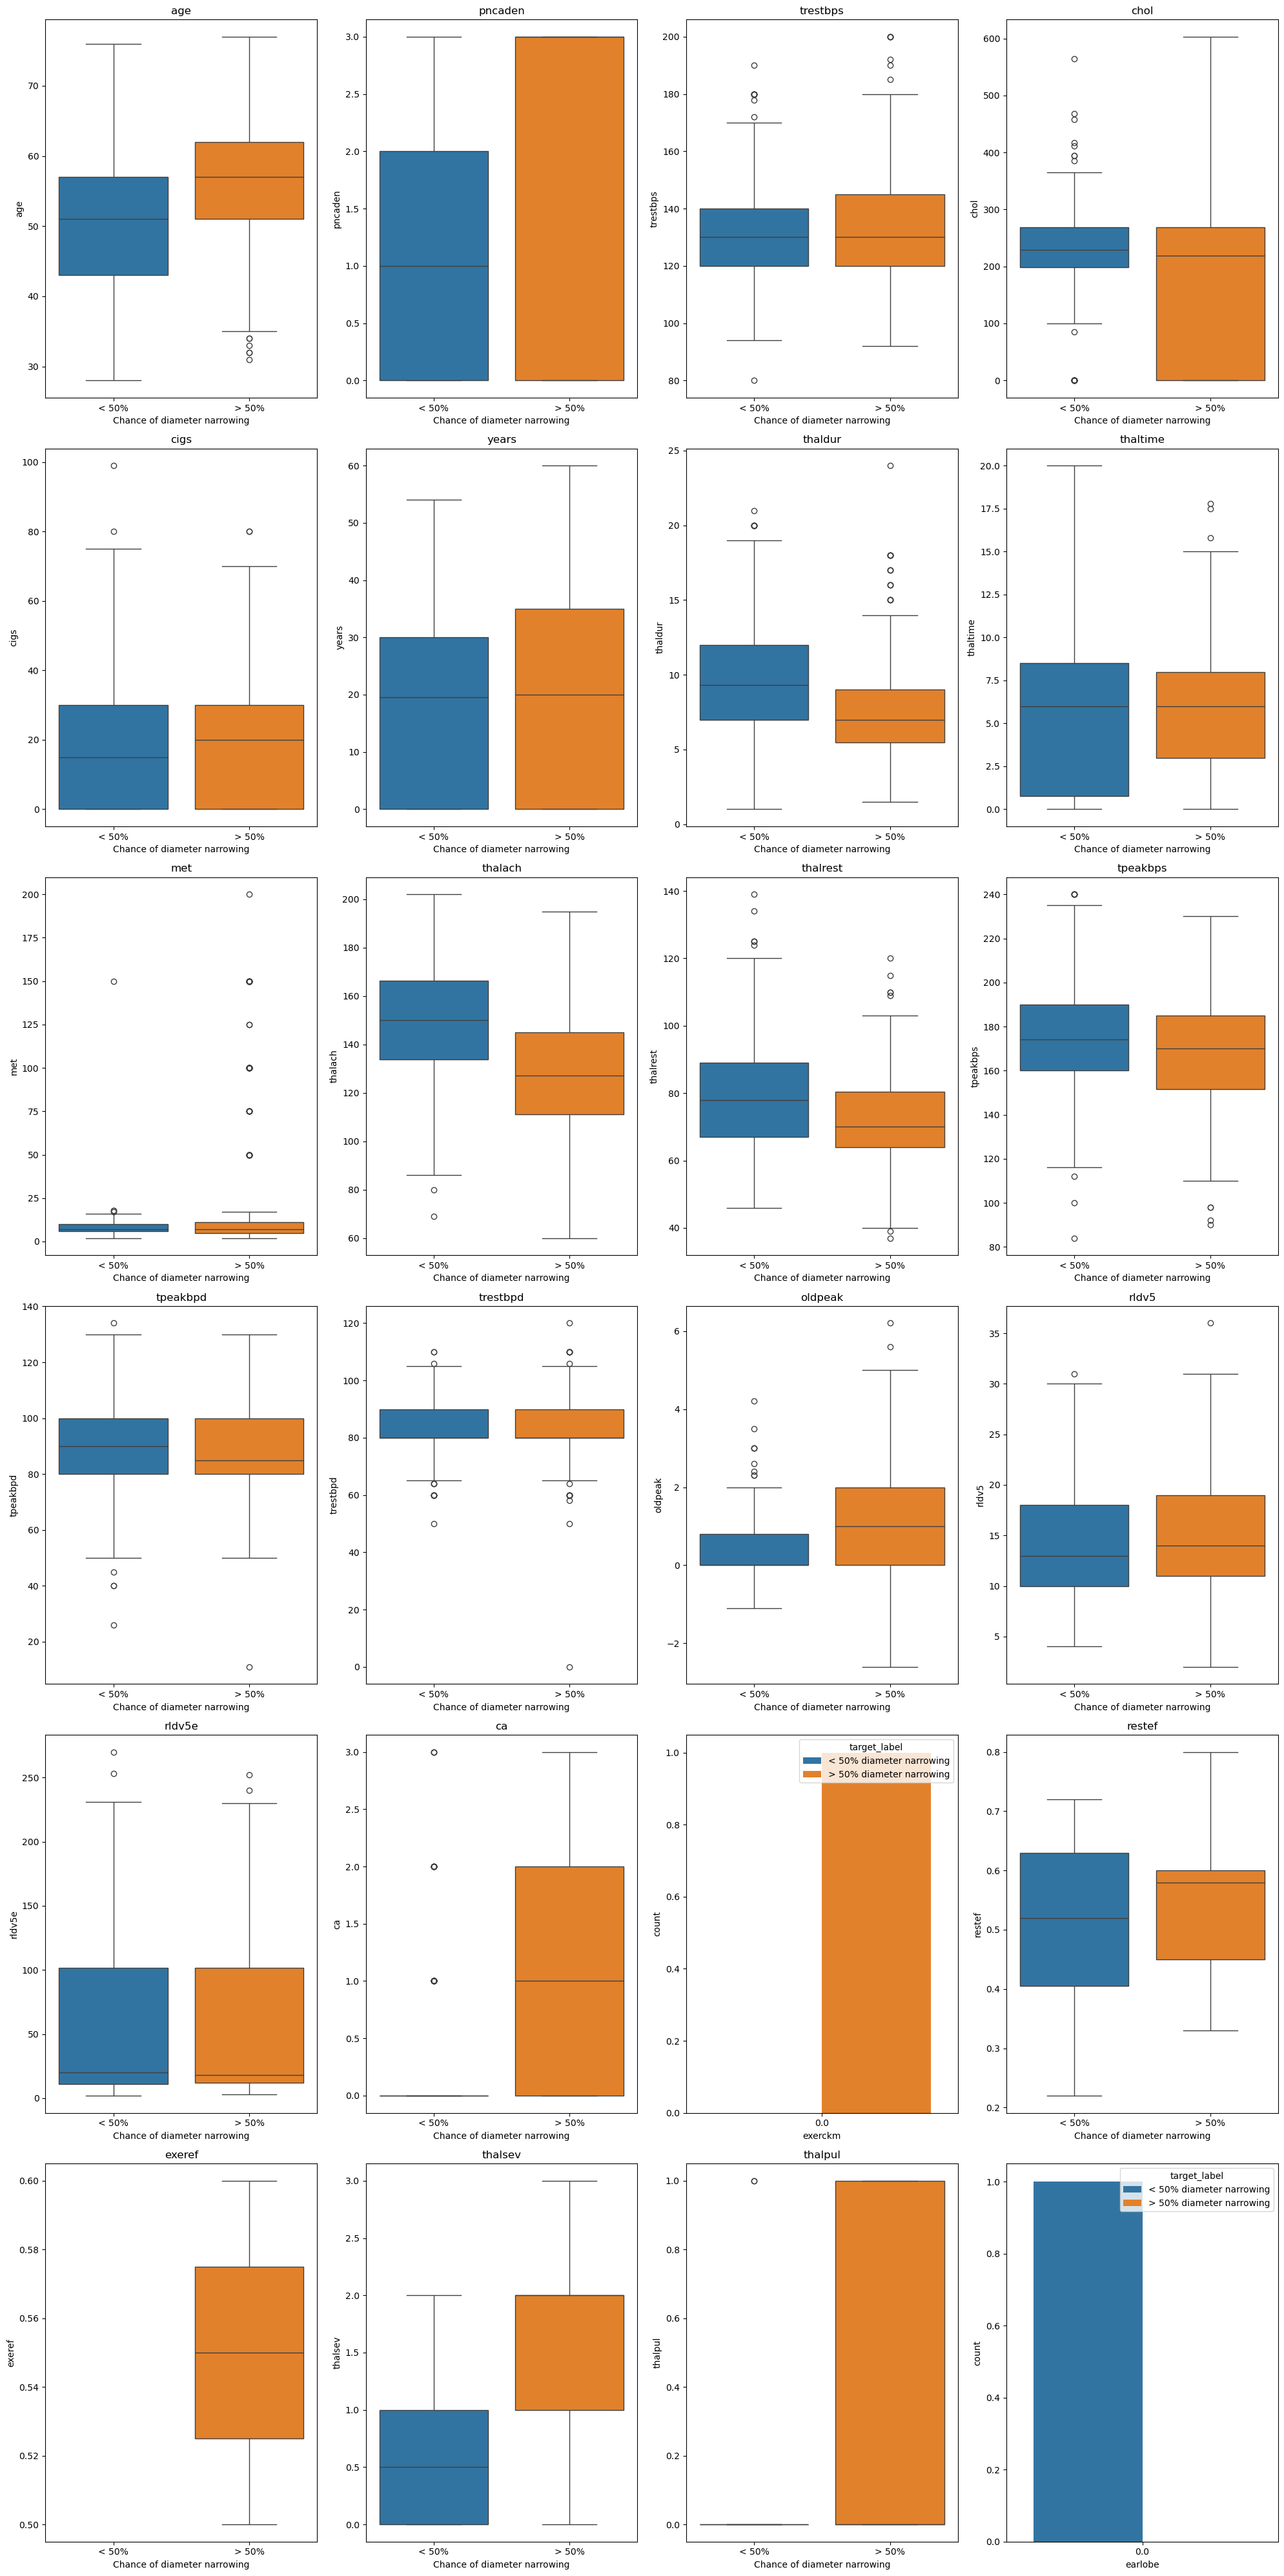

In [29]:
# df = df_feature_trans

fig,axs = plt.subplots(6,4,figsize=(20,40))

for i, ind in enumerate(num_cols):

    if df[ind].count() > 1:
        sns.boxplot(data=df_feature_trans, x='target', y=ind, hue='target', ax=axs[i//4, i%4], legend=False)
        axs[i//4, i%4].set_title(ind)
        axs[i//4, i%4].set_xticks([0, 1])
        axs[i//4, i%4].set_xticklabels(['< 50%', '> 50%'])
        axs[i//4, i%4].set_xlabel('Chance of diameter narrowing')
    else:
        # with only one value, just a bar plot
        grouped_data = df_feature_trans.groupby([ind, 'target_label'], observed=False).size().reset_index(name='count')
        sns.barplot(data=grouped_data, x=ind, y='count', hue='target_label', ax=axs[i//4, i%4])


fig.tight_layout()

For all the numerical columns:
1. age : Older people seem to be at higher risk for heart disease. Those who are younger and have a high risk for heart disease seem to be outliers based on the boxplot outliers.
2. pncaden : does seem to be much of an idicator
3. trestbps (resting blood pressure) : slightly higher values for higher risk of heart disease, but not too much
4. chol : extreme highs and lows for risk of heart disease. Healthy values fall into a tigher range.
5. cigs : daily cigarette use seems similar
6. years (years smoking) : slightly higher for heart diseases, but not too much
7. thaldur (duration of exercise test in minutes) : higher for people with lower risk of heart disease
8. thaltime (time when ST measure depression was noted) : seems to have little indication
9. met (mets achieved) : seems to have little indication
10. thalach (maximum heart rate achieved) : higher for lower risk individuals
11. thalrest (resting heart rate) : higher for lower risk individuals
12. tpeakbps (peak exercise blood pressure (first of 2 parts)) : higher for lower risk individals, but barely
13. tpeakbpd (peak exercise blood pressure (second of 2 parts)) : little indication
14. trestbpd (resting blood pressure) : no difference
15. oldpeak (ST depression induced by exercise relative to rest) : higher for people with higher risk of heart disease, also negative values (might be an error, unclear the range of this metric)
16. rldv5 (height at rest) : slightly higher for high risk
17. rldv5e (height at peak exercise): no indication
18. ca (number of major vessels (0-3) colored by flourosopy) : values higher than 0 is a major indication of heart problems
19. exerckm : only one value and it is for someone at risk
20. restef (rest raidonuclid (sp?) ejection fraction) : seems to be higher on average for higher risk
21. exeref : only values recorded are higher risk
22. thalsev (not used)
23. thalpul (not used)
24. earlobe (not used)

In [30]:
cat_cols = [key for key, value in column_types.items() if value == 'categorical']
len(cat_cols)

30

/tmp/ipykernel_186/533072450.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis tick labels
/tmp/ipykernel_186/533072450.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis tick labels
/tmp/ipykernel_186/533072450.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis tick labels
/tmp/ipykernel_186/533072450.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fixed

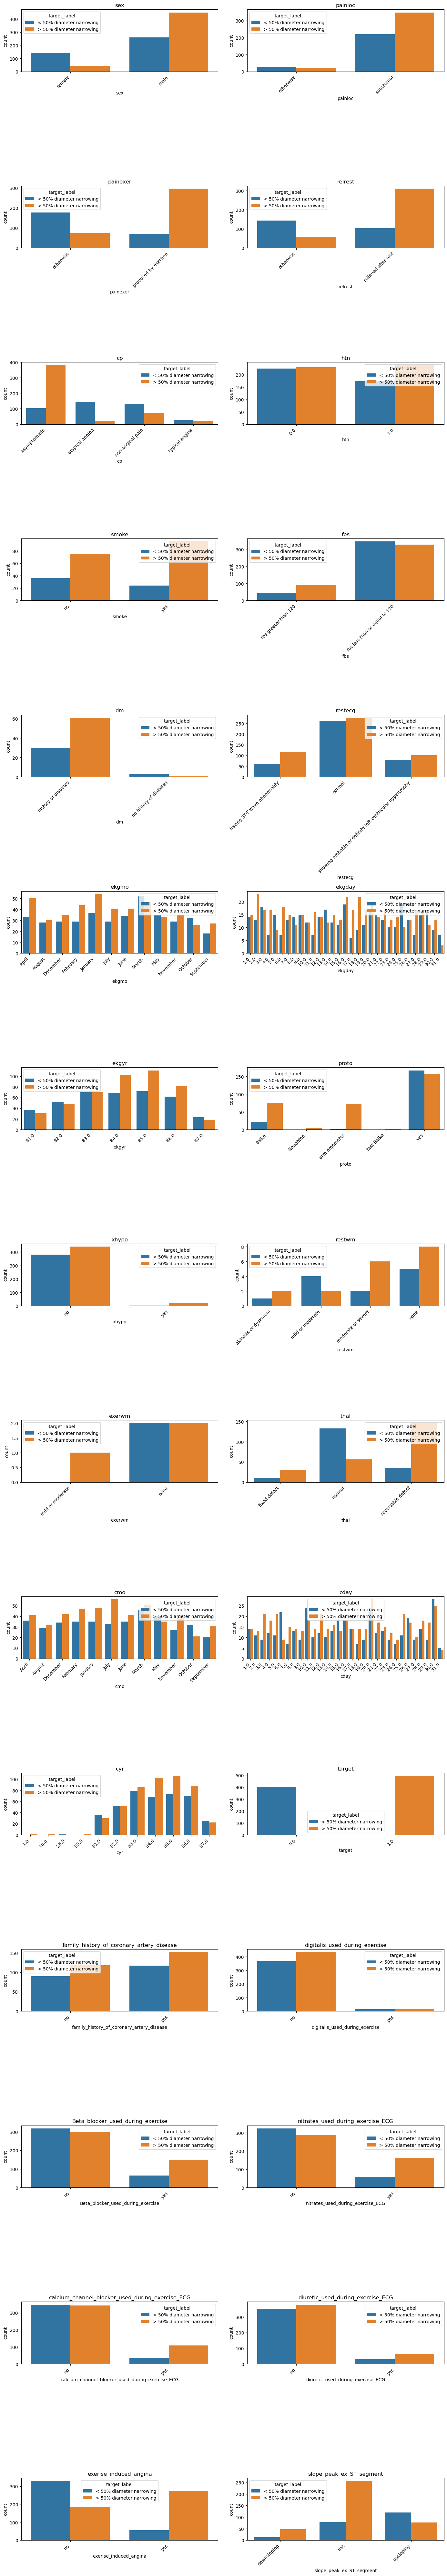

In [31]:
fig,axs = plt.subplots(15,2,figsize=(14,80))

for i,ind in enumerate(cat_cols):
    row = i // 2 
    col = i % 2
    grouped_data = df_feature_trans.groupby([ind, 'target_label'], observed=False).size().reset_index(name='count')
    sns.barplot(data=grouped_data, x=ind, y='count', hue='target_label', ax=axs[row, col])
    axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis tick labels
    axs[row, col].set_title(ind)
    axs[row, col].set_title(ind)
fig.tight_layout()


For all categorical columns:
1. sex : fewer women are at risk of heart disease, more men are at risk of heart disease
2. painloc : substernal pain has higher risk of heart condition, otherwise has little indication
3. painexer : pain provoked by exertion has high indication of heart condition, otherwise has high indication of no heart condition
4. relrest : pain relieved after rest has high indication of heart condition, otherwise has high indication of no heart condition
5. cp : asymptomatic has very high indication of heart condition compared to other types
6. htn : if the value is 1, the patient is more likely to have a heart condition
7. smoke: both smokers and nonsmokers are at risk, but smokers are at a higher risk
8. fbs : fbs greater than 120 indicates higher risk of heart condition, less than 120 is relatively not indicative
9. dm : history of diabetes increases risk of heart disease
10. restecg : abnormalities seem to be more indicative of heart conditions
11. ekgmo : no indication
12. ekgday : no indication
13. ekgyr : no indication
14. proto : Balke seems to show the most indication of heart disease
15. xhypo : most people answered no to this, no indication
16. restwm : mild is the only category that shows low risk
17. exerwm : mild or moderate indicates high risk
18. thal : normal shows low risk
19. cmo : no indication
20. cday : no indication
21. cyr : no indication
22. family history of coronary artery disease : shows little indication
23. digitalis used during exercise : shows little indication
24. beta blocker used during exercise : yes indicates high risk
25. nitrates used during exercise ECG : yes shows indication of high risk
26. calcium channel blocker used during exercise ECG : yes indicates high risk, no has no difference
27. diuretic used during exercise ECG : yes indicates higher risk than no
28. exercise induced angina : yes indicates high risk, no indicates low risk
29. slope peak ex ST segment : flat indicates very high risk, downsloping indicates high risk, upsloping indicates low risk

In [32]:
csv_file_path = "cleaned_data.csv"
df_feature_trans.to_csv(csv_file_path)